# Creating a Sentiment Analysis Web App
## Using PyTorch and SageMaker

_Deep Learning Nanodegree Program | Deployment_

---

In this project, will have a simple web page which a user can use to enter a movie review. The web page will then send the review off to our deployed model which will predict the sentiment of the entered review.



## General Outline


1. Download the data.
2. Process / Prepare the data.
3. Upload the processed data to S3.
4. Train a chosen model.
5. Test the trained model (typically using a batch transform job).
6. Deploy the trained model.
7. Use the deployed model.

In this project, rather than testing the model on its own, I'll be testing the model by deploying the model and then using the deployed model by sending the test data to it. One of the reasons for doing this is so that I can make sure that my deployed model is working correctly before moving forward.

In [1]:
pip install --upgrade sagemaker

  Using cached sagemaker-2.70.0-py2.py3-none-any.whl
  Using cached smdebug_rulesconfig-1.0.1-py2.py3-none-any.whl (20 kB)
  Attempting uninstall: smdebug-rulesconfig
    Found existing installation: smdebug-rulesconfig 0.1.4
    Uninstalling smdebug-rulesconfig-0.1.4:
      Successfully uninstalled smdebug-rulesconfig-0.1.4
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 1.72.0
    Uninstalling sagemaker-1.72.0:
      Successfully uninstalled sagemaker-1.72.0
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Make sure that we use SageMaker 1.x
!pip install sagemaker==1.72.0

  Using cached sagemaker-1.72.0-py2.py3-none-any.whl
  Using cached smdebug_rulesconfig-0.1.4-py2.py3-none-any.whl (10 kB)
  Attempting uninstall: smdebug-rulesconfig
    Found existing installation: smdebug-rulesconfig 1.0.1
    Uninstalling smdebug-rulesconfig-1.0.1:
      Successfully uninstalled smdebug-rulesconfig-1.0.1
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.70.0
    Uninstalling sagemaker-2.70.0:
      Successfully uninstalled sagemaker-2.70.0
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


## Step 1: Downloading the data

In [3]:
%mkdir ../data
!wget -O ../data/aclImdb_v1.tar.gz http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -zxf ../data/aclImdb_v1.tar.gz -C ../data

mkdir: cannot create directory ‘../data’: File exists
--2021-12-10 16:46:56--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘../data/aclImdb_v1.tar.gz’

../data/aclImdb_v1. 100%[===================>]  80.23M  23.9MB/s    in 4.5s    

2021-12-10 16:47:00 (17.9 MB/s) - ‘../data/aclImdb_v1.tar.gz’ saved [84125825/84125825]



## Step 2: Preparing and Processing the data

First, we will do some initial data processing. To begin with, we will read in each of the reviews and combine them into a single input structure. Then, we will split the dataset into a training set and a testing set.

In [4]:
import os
import glob

def read_imdb_data(data_dir='../data/aclImdb'):
    data = {}
    labels = {}
    
    for data_type in ['train', 'test']:
        data[data_type] = {}
        labels[data_type] = {}
        
        for sentiment in ['pos', 'neg']:
            data[data_type][sentiment] = []
            labels[data_type][sentiment] = []
            
            path = os.path.join(data_dir, data_type, sentiment, '*.txt')
            files = glob.glob(path)
            
            for f in files:
                with open(f) as review:
                    data[data_type][sentiment].append(review.read())
                    # Here we represent a positive review by '1' and a negative review by '0'
                    labels[data_type][sentiment].append(1 if sentiment == 'pos' else 0)
                    
            assert len(data[data_type][sentiment]) == len(labels[data_type][sentiment]), \
                    "{}/{} data size does not match labels size".format(data_type, sentiment)
                
    return data, labels

In [5]:
data, labels = read_imdb_data()
print("IMDB reviews: train = {} pos / {} neg, test = {} pos / {} neg".format(
            len(data['train']['pos']), len(data['train']['neg']),
            len(data['test']['pos']), len(data['test']['neg'])))

IMDB reviews: train = 12500 pos / 12500 neg, test = 12500 pos / 12500 neg


Here we will combine the positive and negative reviews and shuffle the resulting records.

In [6]:
from sklearn.utils import shuffle

def prepare_imdb_data(data, labels):
    """Prepare training and test sets from IMDb movie reviews."""
    
    #Combine positive and negative reviews and labels
    data_train = data['train']['pos'] + data['train']['neg']
    data_test = data['test']['pos'] + data['test']['neg']
    labels_train = labels['train']['pos'] + labels['train']['neg']
    labels_test = labels['test']['pos'] + labels['test']['neg']
    
    #Shuffle reviews and corresponding labels within training and test sets
    data_train, labels_train = shuffle(data_train, labels_train)
    data_test, labels_test = shuffle(data_test, labels_test)
    
    # Return a unified training data, test data, training labels, test labets
    return data_train, data_test, labels_train, labels_test

In [7]:
train_X, test_X, train_y, test_y = prepare_imdb_data(data, labels)
print("IMDb reviews (combined): train = {}, test = {}".format(len(train_X), len(test_X)))

IMDb reviews (combined): train = 25000, test = 25000


Now that we have our training and testing sets unified and prepared, we should do a quick check and see an example of the data our model will be trained on. This is generally a good idea as it allows us to see how each of the further processing steps affects the reviews and it also ensures that the data has been loaded correctly.

In [8]:
print(train_X[100])
print(train_y[100])

Marvelous film again dealing with the trials and tribulations of World War 11 England. What makes this film so good is the touching of the human element.This film is definitely in the tradition of such British line classics such as "Mrs. Miniver" and "Hope and Glory." As is the case with this film, we see the desperation of people in the time of war.<br /><br />The performances are outstanding here especially by the embittered John Thaw, who is assigned a child who has been evacuated from the London bombing.<br /><br />We soon see why this child wets his bed. He comes from a lunatic mother who has abused him terribly.<br /><br />The old man takes to the child and brings happiness into his sad life. When the child is returned to his mother, the old man goes to London and seeks him out only to find tragedy. He literally kidnaps the boy and is able to convince a higher up that the child is better off with him than being in a boy's home.<br /><br />The picture is so good because it deals a

The first step in processing the reviews is to make sure that any html tags that appear should be removed. In addition we wish to tokenize our input, that way words such as *entertained* and *entertaining* are considered the same with regard to sentiment analysis.

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *

import re
from bs4 import BeautifulSoup

def review_to_words(review):
    nltk.download("stopwords", quiet=True)
    stemmer = PorterStemmer()
    
    text = BeautifulSoup(review, "html.parser").get_text() # Remove HTML tags
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower()) # Convert to lower case
    words = text.split() # Split string into words
    words = [w for w in words if w not in stopwords.words("english")] # Remove stopwords
    words = [PorterStemmer().stem(w) for w in words] # stem
    
    return words

The `review_to_words` method defined above uses `BeautifulSoup` to remove any html tags that appear and uses the `nltk` package to tokenize the reviews. Here we apply `review_to_words` to one of the reviews in the training set.

In [10]:
# Applying review_to_words to a review 
review_to_words(train_X[100])

['marvel',
 'film',
 'deal',
 'trial',
 'tribul',
 'world',
 'war',
 '11',
 'england',
 'make',
 'film',
 'good',
 'touch',
 'human',
 'element',
 'film',
 'definit',
 'tradit',
 'british',
 'line',
 'classic',
 'mr',
 'miniv',
 'hope',
 'glori',
 'case',
 'film',
 'see',
 'desper',
 'peopl',
 'time',
 'war',
 'perform',
 'outstand',
 'especi',
 'embitt',
 'john',
 'thaw',
 'assign',
 'child',
 'evacu',
 'london',
 'bomb',
 'soon',
 'see',
 'child',
 'wet',
 'bed',
 'come',
 'lunat',
 'mother',
 'abus',
 'terribl',
 'old',
 'man',
 'take',
 'child',
 'bring',
 'happi',
 'sad',
 'life',
 'child',
 'return',
 'mother',
 'old',
 'man',
 'goe',
 'london',
 'seek',
 'find',
 'tragedi',
 'liter',
 'kidnap',
 'boy',
 'abl',
 'convinc',
 'higher',
 'child',
 'better',
 'boy',
 'home',
 'pictur',
 'good',
 'deal',
 'build',
 'endear',
 'relationship']

The method below applies the `review_to_words` method to each of the reviews in the training and testing datasets. In addition it caches the results. This is because performing this processing step can take a long time. 

In [11]:
import pickle

cache_dir = os.path.join("../cache", "sentiment_analysis")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

def preprocess_data(data_train, data_test, labels_train, labels_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        #words_train = list(map(review_to_words, data_train))
        #words_test = list(map(review_to_words, data_test))
        words_train = [review_to_words(review) for review in data_train]
        words_test = [review_to_words(review) for review in data_test]
        
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_test, labels_train, labels_test = (cache_data['words_train'],
                cache_data['words_test'], cache_data['labels_train'], cache_data['labels_test'])
    
    return words_train, words_test, labels_train, labels_test

In [12]:
# Preprocess data
train_X, test_X, train_y, test_y = preprocess_data(train_X, test_X, train_y, test_y)

Read preprocessed data from cache file: preprocessed_data.pkl


## Transform the data

In this project, we will transform the data from its word representation to a bag-of-words feature representation. To start, we will represent each word as an integer. Of course, some of the words that appear in the reviews occur very infrequently and so likely don't contain much information for the purposes of sentiment analysis. The way we will deal with this problem is that we will fix the size of the working vocabulary and we will only include the words that appear most frequently. We will then combine all of the infrequent words into a single category and, in our case, we will label it as `1`.

Since we will be using a recurrent neural network, it will be convenient if the length of each review is the same. To do this, we will fix a size of our reviews and then pad short reviews with the category 'no word' (which I will label `0`) and truncate long reviews.

###  Create a word dictionary

To begin with, will construct a way to map words that appear in the reviews to integers. Here we fix the size of our vocabulary (including the 'no word' and 'infrequent' categories) to be `5000`. This number can be changed later to see how it affects the model, but will stick with for now.

In [1]:
import numpy as np

def build_dict(data, vocab_size = 5000):
    """Construct and return a dictionary mapping each of the most frequently appearing words to a unique integer."""
    
    # Determining how often each word appears in `data`. Note that `data` is a list of sentences and that a
    # sentence is a list of words.
    
    word_count = {} # A dict storing the words that appear in the reviews along with how often they occur
    for sentences in data:
        for word in sentences:
            if word in word_count:
                word_count[word] += 1
            else:
                word_count[word] = 1
                
    #Sorting the words found in `data` so that sorted_words[0] is the most frequently appearing word and
    #sorted_words[-1] is the least frequently appearing word.
    
    sorted_words = sorted(word_count, key = word_count.get, reverse=True)
    
    word_dict = {} # This is what we are building, a dictionary that translates words into integers
    for idx, word in enumerate(sorted_words[:vocab_size - 2]): # The -2 is so that we save room for the 'no word'
        word_dict[word] = idx + 2                              # 'infrequent' labels
        
    return word_dict

In [14]:
word_dict = build_dict(train_X)

### Save `word_dict`

Later on when we construct an endpoint which processes a submitted review we will need to make use of the `word_dict` which we have created. As such, we will save it to a file now for future use.

In [16]:
data_dir = '../data/pytorch' # The folder we will use for storing data
if not os.path.exists(data_dir): # Make sure that the folder exists
    os.makedirs(data_dir)

In [17]:
with open(os.path.join(data_dir, 'word_dict.pkl'), "wb") as f:
    pickle.dump(word_dict, f)

### Transform the reviews

Now that we have our word dictionary which allows us to transform the words appearing in the reviews into integers, it is time to make use of it and convert our reviews to their integer sequence representation, making sure to pad or truncate to a fixed length, which in our case is `500`.

In [18]:
def convert_and_pad(word_dict, sentence, pad=500):
    NOWORD = 0 # We will use 0 to represent the 'no word' category
    INFREQ = 1 # and we use 1 to represent the infrequent words, i.e., words not appearing in word_dict
    
    working_sentence = [NOWORD] * pad
    
    for word_index, word in enumerate(sentence[:pad]):
        if word in word_dict:
            working_sentence[word_index] = word_dict[word]
        else:
            working_sentence[word_index] = INFREQ
            
    return working_sentence, min(len(sentence), pad)

def convert_and_pad_data(word_dict, data, pad=500):
    result = []
    lengths = []
    
    for sentence in data:
        converted, leng = convert_and_pad(word_dict, sentence, pad)
        result.append(converted)
        lengths.append(leng)
        
    return np.array(result), np.array(lengths)

In [19]:
train_X, train_X_len = convert_and_pad_data(word_dict, train_X)
test_X, test_X_len = convert_and_pad_data(word_dict, test_X)

## Step 3: Upload the data to S3

Now we will upload the training dataset to S3 in order for our training code to access it. For now we will save it locally and we will upload to S3 later on.

### Save the processed training dataset locally

It is important to note the format of the data that we are saving as we will need to know it when we write the training code. In our case, each row of the dataset has the form `label`, `length`, `review[500]` where `review[500]` is a sequence of `500` integers representing the words in the review.

In [21]:
import pandas as pd
    
pd.concat([pd.DataFrame(train_y), pd.DataFrame(train_X_len), pd.DataFrame(train_X)], axis=1) \
        .to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

### Uploading the training data


Next, we need to upload the training data to the SageMaker default S3 bucket so that we can provide access to it while training our model.

In [22]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/sentiment_rnn'

role = sagemaker.get_execution_role()

In [23]:
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)
print(input_data)

s3://sagemaker-us-east-1-194770695442/sagemaker/sentiment_rnn


**NOTE:** The cell above uploads the entire contents of our data directory. This includes the `word_dict.pkl` file. This is fortunate as we will need this later on when we create an endpoint that accepts an arbitrary review. For now, we will just take note of the fact that it resides in the data directory (and so also in the S3 training bucket) and that we will need to make sure it gets saved in the model directory.

## Step 4: Build and Train the PyTorch Model

A model comprises of three objects each of which interact with one another, these are:
 - Model Artifacts
 - Training Code
 - Inference Code
 
In this project we will use containers provided by Amazon. We will start by implementing our own neural network in PyTorch along with a training script.

In [24]:
!pygmentize train/model.py

import torch.nn as nn

class LSTMClassifier(nn.Module):
    """
    This is the simple RNN model we will be using to perform Sentiment Analysis.
    """

    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        """
        Initialize the model by settingg up the various layers.
        """
        super(LSTMClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.dense = nn.Linear(in_features=hidden_dim, out_features=1)
        self.sig = nn.Sigmoid()
        
        self.word_dict = None

    def forward(self, x):
        """
        Perform a forward pass of our model on some input.
        """
        x = x.t()
        lengths = x[0,:]
        reviews = x[1:,:]
        embeds = self.embedding(reviews)
        lstm_out, _ = self.lstm(embeds)
        out = self.dense(lstm_out)
        out = out[lengths - 1, range(len(lengths))]
        return self.sig

In [25]:
import torch
import torch.utils.data

# Reading in only the first 250 rows
train_sample = pd.read_csv(os.path.join(data_dir, 'train.csv'), header=None, names=None, nrows=250)

# Turning the input pandas dataframe into tensors
train_sample_y = torch.from_numpy(train_sample[[0]].values).float().squeeze()
train_sample_X = torch.from_numpy(train_sample.drop([0], axis=1).values).long()

# Building the dataset
train_sample_ds = torch.utils.data.TensorDataset(train_sample_X, train_sample_y)
# Building the dataloader
train_sample_dl = torch.utils.data.DataLoader(train_sample_ds, batch_size=50)

### Writing the training method

In [26]:
def train(model, train_loader, epochs, optimizer, loss_fn, device):
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for batch in train_loader:         
            batch_X, batch_y = batch
            
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            # Train method to train the model.
            optimizer.zero_grad()
            output = model.forward(batch_X)
            loss = loss_fn(output ,batch_y)
            loss.backward()
            optimizer.step()
        
        
            total_loss += loss.data.item()
        print("Epoch: {}, BCELoss: {}".format(epoch, total_loss / len(train_loader)))

Supposing we have the training method above, we will test that it is working by writing a bit of code in the notebook that executes our training method on the small sample training set that we loaded earlier. The reason for doing this in the notebook is so that we have an opportunity to fix any errors that arise early when they are easier to diagnose.

Now we will test the training method we created. The reason for doing this is to have an opportunity to fix any errors that may arise. 

In [27]:
import torch.optim as optim
from train.model import LSTMClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(32, 100, 5000).to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCELoss()

train(model, train_sample_dl, 5, optimizer, loss_fn, device)

Epoch: 1, BCELoss: 0.6923724174499511
Epoch: 2, BCELoss: 0.6841827034950256
Epoch: 3, BCELoss: 0.6773098230361938
Epoch: 4, BCELoss: 0.6696451425552368
Epoch: 5, BCELoss: 0.6600737690925598


In order to construct a PyTorch model using SageMaker we must provide SageMaker with a training script. We may optionally include a directory which will be copied to the container and from which our training code will be run. When the training container is executed it will check the uploaded directory (if there is one) for a `requirements.txt` file and install any required Python libraries, after which the training script will be run.

### Training the model

When a PyTorch model is constructed in SageMaker, an entry point must be specified. This is the Python file which will be executed when the model is trained. The way that SageMaker passes hyperparameters to the training script is by way of arguments. These arguments can then be parsed and used in the training script. 

In [28]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="train.py",
                    source_dir="train",
                    role=role,
                    framework_version='0.4.0',
                    py_version = 'py3',
                    train_instance_count=1,
                    train_instance_type='ml.m4.xlarge',
                    hyperparameters={
                        'epochs': 10,
                        'hidden_dim': 200,
                    })

In [29]:
estimator.fit({'training':input_data})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2021-12-10 16:49:44 Starting - Starting the training job...
2021-12-10 16:49:58 Starting - Launching requested ML instances......
2021-12-10 16:51:00 Starting - Preparing the instances for training.........
2021-12-10 16:52:38 Downloading - Downloading input data...
2021-12-10 16:53:10 Training - Downloading the training image...
2021-12-10 16:53:30 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-12-10 16:53:31,846 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-12-10 16:53:31,849 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-12-10 16:53:31,862 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-12-10 16:53:31,866 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-12-10 16:53:32,139 sagemaker-containers 

Epoch: 1, BCELoss: 0.6740944653141255
Epoch: 2, BCELoss: 0.5928870816620029
Epoch: 3, BCELoss: 0.49164923113219594
Epoch: 4, BCELoss: 0.42751517222852126
Epoch: 5, BCELoss: 0.39137507336480276
Epoch: 6, BCELoss: 0.357730895280838
Epoch: 7, BCELoss: 0.3451343111845912
Epoch: 8, BCELoss: 0.304596371492561
Epoch: 9, BCELoss: 0.2817097637726336
Epoch: 10, BCELoss: 0.2684760416040615
2021-12-10 18:39:42,386 sagemaker-containers INFO     Reporting training SUCCESS

2021-12-10 18:40:45 Uploading - Uploading generated training model
2021-12-10 18:40:45 Completed - Training job completed
Training seconds: 6487
Billable seconds: 6487


## Step 5: Testing the model

As mentioned at the beginning of this project, we will be testing the model by first deploying it and then sending the testing data to the deployed endpoint. We will do this so that we can make sure that the deployed model is working correctly.

## Step 6: Deploy the model for testing

In [30]:
# TODO: Deploy the trained model
predictor = estimator.deploy(initial_instance_count = 1, instance_type='ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


------!

## Step 7 - Use the model for testing

Once deployed, we can read in the test data and send it off to our deployed model to get some results. Once we collect all of the results we can determine how accurate our model is.

In [31]:
test_X = pd.concat([pd.DataFrame(test_X_len), pd.DataFrame(test_X)], axis=1)

In [32]:
# Splitting the data into chunks and sending each chunk seperately, accumulating the results.

def predict(data, rows=512):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = np.array([])
    for array in split_array:
        predictions = np.append(predictions, predictor.predict(array))
    
    return predictions

In [33]:
predictions = predict(test_X.values)
predictions = [round(num) for num in predictions]

In [34]:
from sklearn.metrics import accuracy_score
accuracy_score(test_y, predictions)

0.84428

### More testing

Now we have a trained model which has been deployed and which we can send processed reviews to and which returns the predicted sentiment. However, ultimately we would like to be able to send our model an unprocessed review. That is, we would like to send the review itself as a string. For example, suppose we wish to send the following review to our model.

In [35]:
test_review = 'The simplest pleasures in life are the best, and this film is one of them. Combining a rather basic storyline of love and adventure this movie transcends the usual weekend fair with wit and unmitigated charm.'

In [36]:
# Convert test_review into a form usable by the model and save the results in test_data
test_review_words = review_to_words(test_review)
review_x, review_len = (convert_and_pad(word_dict, test_review_words))

data_pack = np.hstack((review_len, review_x))
data_pack = data_pack.reshape(1, -1)

test_data = torch.from_numpy(data_pack)
test_data = test_data.to(device)

In [37]:
test_data

tensor([[  20,    1, 1374,   49,   53,    3,    4,  878,  173,  392,  682,   29,
          723,    2, 4434,  275, 2079, 1060,  760,    1,  580,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,  

Now that we have processed the review, we can send the resulting array to our model to predict the sentiment of the review.

In [38]:
predictor.predict(test_data)

array(0.8523436, dtype=float32)

Since the return value of our model is close to `1`, we can be certain that the review we submitted is positive.

## Delete the endpoint

In SageMaker, once we've deployed an endpoint it continues to run, therefore we will shut it down. 

In [39]:
predictor.delete_endpoint()

## Step 6- Deploy the model for the web app

In [2]:
!pygmentize serve/predict.py

import argparse
import json
import os
import pickle
import sys
import sagemaker_containers
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

from model import LSTMClassifier

from utils import review_to_words, convert_and_pad

def model_fn(model_dir):
    """Load the PyTorch model from the `model_dir` directory."""
    print("Loading model.")

    # First, loading the parameters used to create the model.
    model_info = {}
    model_info_path = os.path.join(model_dir, 'model_info.pth')
    with open(model_info_path, 'rb') as f:
        model_info = torch.load(f)

    print("model_info: {}".format(model_info))

    # Determining the device and construct the model.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMClassifier(model_info['embedding_dim'], model_info['hidden_dim'], model_info['vocab_size'])

    # Loading the store model parameters.
    model_path = os.path.

### Deploying the model

Now that the custom inference code has been written, we will create and deploy our model. To begin with, we need to construct a new PyTorchModel object which points to the model artifacts created during training and also points to the inference code that we wish to use. Then we can call the deploy method to launch the deployment container.

In [41]:
from sagemaker.predictor import RealTimePredictor
from sagemaker.pytorch import PyTorchModel

class StringPredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(StringPredictor, self).__init__(endpoint_name, sagemaker_session, content_type= 'text/plain')

model = PyTorchModel(model_data=estimator.model_data,
                     role = role,
                     framework_version='0.4.0',
                     py_version = 'py3',
                     entry_point='predict.py',
                     source_dir='serve',
                     predictor_cls=StringPredictor)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [42]:
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


---------!

### Testing the model

Now that we have deployed our model with the custom inference code, we should test to see if everything is working. Here we test our model by loading the first `250` positive and negative reviews and send them to the endpoint, then collect the results. The reason for only sending some of the data is that the amount of time it takes for our model to process the input and then perform inference is quite long and so testing the entire data set would be prohibitive.

In [43]:
import glob

def test_reviews(data_dir='../data/aclImdb', stop=250):
    
    results = []
    ground = []
    
    # Testing both positive and negative reviews    
    for sentiment in ['pos', 'neg']:
        
        path = os.path.join(data_dir, 'test', sentiment, '*.txt')
        files = glob.glob(path)
        
        files_read = 0
        
        print('Starting ', sentiment, ' files')
        
        # Iterating through the files and sending them to the predictor
        for f in files:
            with open(f) as review:
                # Storing the ground truth (was the review positive or negative)
                if sentiment == 'pos':
                    ground.append(1)
                else:
                    ground.append(0)
                # Reading in the review and convert to 'utf-8' 
                review_input = review.read().encode('utf-8')
                # Sending the review to the predictor and store the results
                rlt = predictor.predict(review_input)
                rtn = 1 if(b'1.0' == rlt) else 0
                results.append(rtn)
                
            # Sending reviews to our endpoint one at a time takes a while so we
            # only send a small number of reviews
            files_read += 1
            if files_read == stop:
                break
            
    return ground, results

In [44]:
ground, results = test_reviews()

Starting  pos  files
Starting  neg  files


In [45]:
from sklearn.metrics import accuracy_score
accuracy_score(ground, results)

0.84

As an additional test, we can try sending the `test_review` that we looked at earlier.

In [46]:
predictor.predict(test_review)

b'1.0'

Now that we know our endpoint is working as expected, we can set up the web page that will interact with it. 

## Step 7 (again): Use the model for the web app

In [47]:
predictor.endpoint

'sagemaker-pytorch-2021-12-10-18-51-12-139'

## Step 4: Deploying our web app

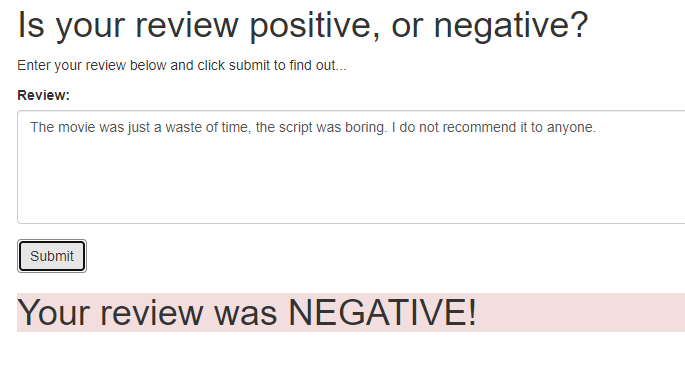

### Deleting the endpoint

Remember to always shut down your endpoint if you are no longer using it. You are charged for the length of time that the endpoint is running so if you forget and leave it on you could end up with an unexpectedly large bill.

Again, SageMaker charges for the length of time that the endpoint is running and this could end up with unexpectedly large bill. Therefore, will shut down the endpoint.

In [48]:
predictor.delete_endpoint()